In [1]:
# Try to understand Zackay+Ofek paper II

In [2]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,8)
from matplotlib.patches import Polygon
import pylab as plt
import numpy as np
import fitsio
from astrometry.util.fits import *
from astrometry.util.util import Tan
from astrometry.util.plotutils import *
from astrometry.libkd.spherematch import match_radec
from collections import Counter
from astrometry.util.starutil import *
from scipy.ndimage.filters import *
from scipy.ndimage.measurements import label, find_objects
from scipy.ndimage.morphology import binary_dilation, binary_fill_holes

In [238]:
H,W = 64,64 #256,256
psf_s1 = 2.
psf_s2 = 8.
F1 = 1.
F2 = 1.
sig_1 = 1.
sig_2 = 1.
xx,yy = np.meshgrid(np.arange(W), np.arange(H))
cx,cy = W//2, H//2
cx1 = cx
cx2 = cx
img1 = np.exp(-0.5 * ((xx-cx1)**2 + (yy-cy)**2)/psf_s1**2)
img1 /= np.sum(img1)
img2 = np.exp(-0.5 * ((xx-cx2)**2 + (yy-cy)**2)/psf_s2**2)
img2 /= np.sum(img2)

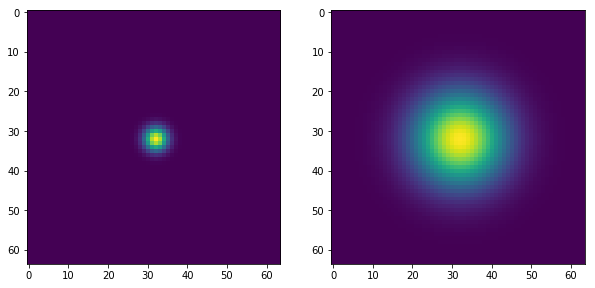

In [239]:
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2);

In [240]:
psf1 = img1
psf2 = img2

In [241]:
P1 = np.fft.rfft2(psf1)
P1.dtype
print(P1.real.min(), P1.real.max())
print(P1.imag.min(), P1.imag.max())
P2 = np.fft.rfft2(psf2)
P2.dtype
print(P2.real.min(), P2.real.max())
print(P2.imag.min(), P2.imag.max())

-0.9809080339138543 1.0
-2.205423072897811e-15 1.946481712790382e-15
-0.7347133781027048 1.0
-1.35448916834449e-15 1.5959455978986625e-15


In [242]:
# Image FFTs = PSF FFTs
M1 = P1
M2 = P2

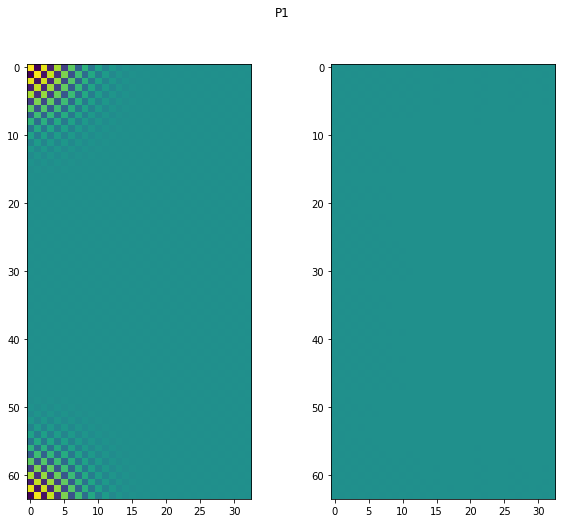

In [243]:
plt.subplot(1,2,1)
plt.imshow(P1.real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow(P1.imag, vmin=-1, vmax=1);
plt.suptitle('P1');

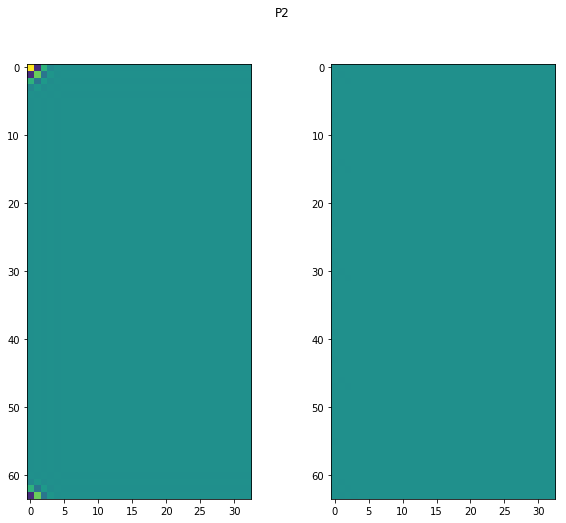

In [244]:
plt.subplot(1,2,1)
plt.imshow(P2.real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow(P2.imag, vmin=-1, vmax=1)
plt.suptitle('P2');

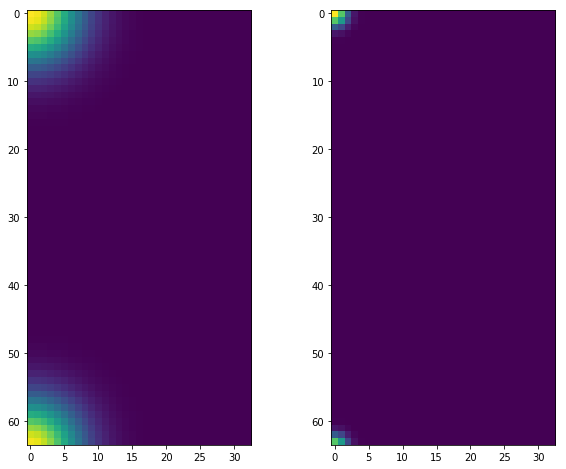

In [245]:
plt.subplot(1,2,1)
plt.imshow(np.abs(P1), vmin=0, vmax=1)
plt.subplot(1,2,2)
plt.imshow(np.abs(P2), vmin=0, vmax=1);

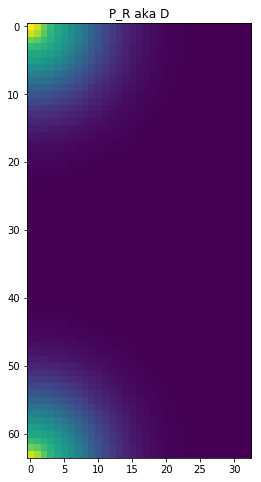

In [275]:
D = np.sqrt((F1**2 / sig_1**2) * np.abs(P1) + (F2**2 / sig_2**2) * np.abs(P2))
plt.imshow(D)
plt.title('P_R aka D');

In [247]:
N = (F1 / sig_1**2) * (P1 * M1) + (F2 / sig_2**2) * (P2 * M2)

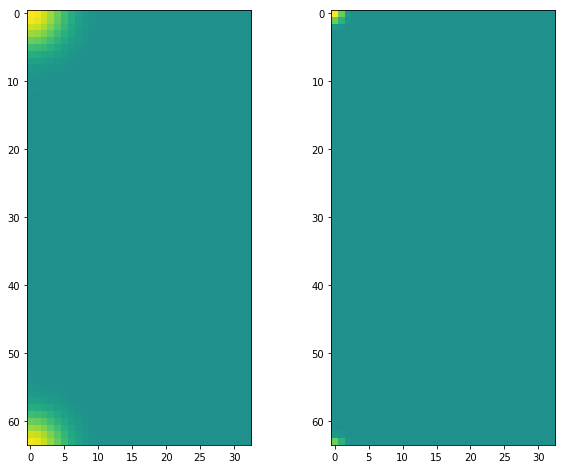

In [248]:
plt.subplot(1,2,1)
plt.imshow((P1 * M1).real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow((P2 * M2).real, vmin=-1, vmax=1);

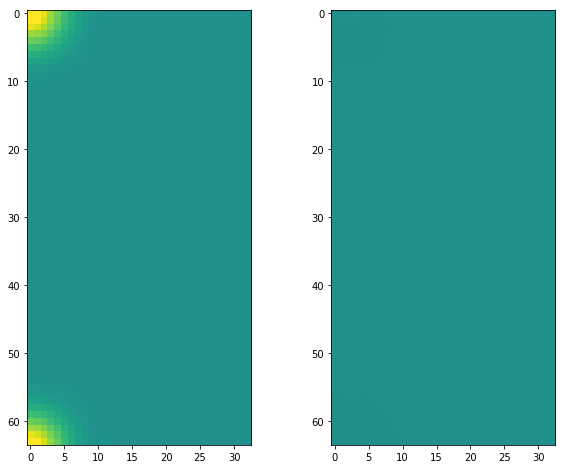

In [249]:
plt.subplot(1,2,1)
plt.imshow(N.real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow(N.imag, vmin=-1, vmax=1);

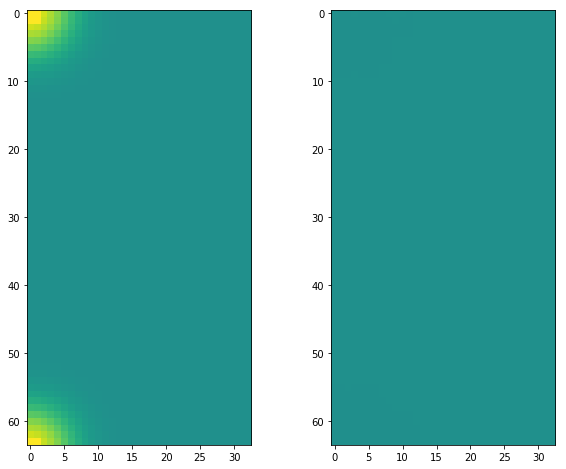

In [250]:
plt.subplot(1,2,1)
plt.imshow((N/D).real, vmin=-1, vmax=1)
plt.subplot(1,2,2)
plt.imshow((N/D).imag, vmin=-1, vmax=1);

In [251]:
R = N/D
R.dtype, R.shape

(dtype('complex128'), (64, 33))

In [252]:
imgR = np.fft.irfft2(R)
imgR = np.fft.ifftshift(imgR)
imgR.dtype, imgR.shape

(dtype('float64'), (64, 64))

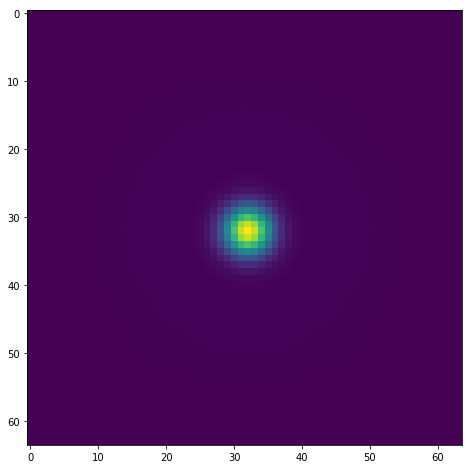

In [253]:
plt.imshow(imgR);

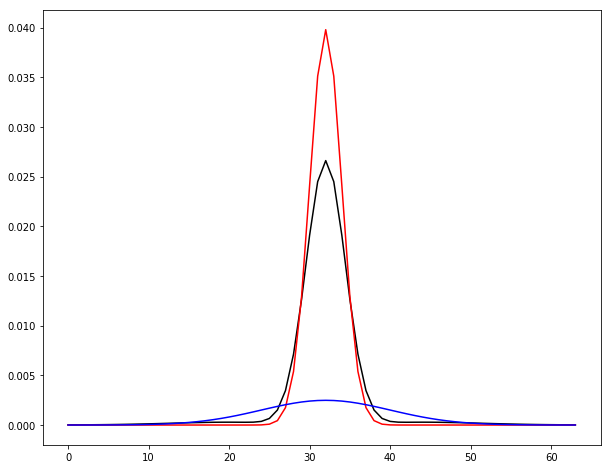

In [254]:
plt.plot(imgR[cy,:], color='k')
plt.plot(img1[cy,:], color='r')
plt.plot(img2[cy,:], color='b')

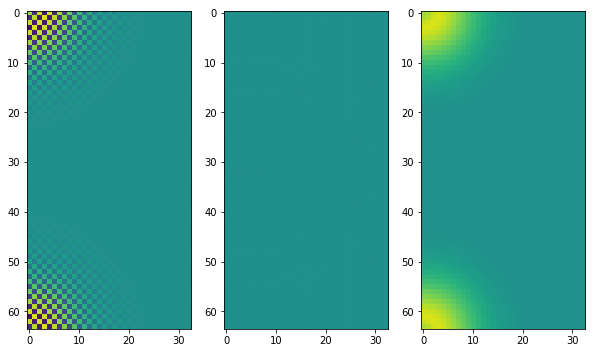

In [276]:
plt.subplot(1,3,1)
plt.imshow((P1 / D).real, vmin=-1, vmax=1)
plt.subplot(1,3,2)
plt.imshow((P1 / D).imag, vmin=-1, vmax=1)
plt.subplot(1,3,3)
plt.imshow(np.abs(P1 / D), vmin=-1, vmax=1);

In [260]:
# ic1 is the effective convolution kernel to go from img1 to R
ic1 = np.fft.irfft2(P1/D)
ic1.dtype, ic1.shape

(dtype('float64'), (64, 64))

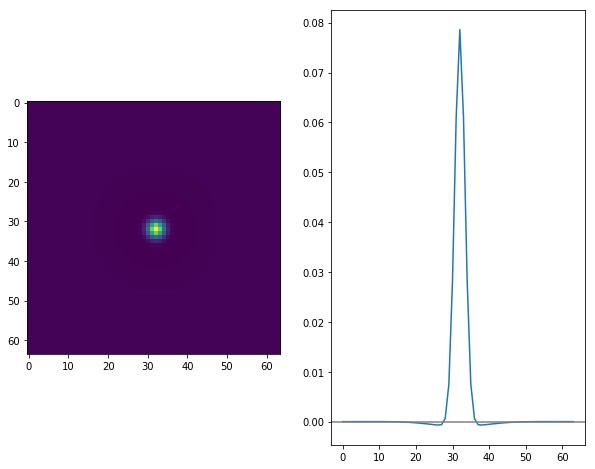

In [284]:
plt.subplot(1,2,1)
plt.imshow(ic1) #, cmap='RdBu', vmin=-0.05, vmax=0.05)
#plt.axis([cx-15,cx+15,cy-15,cy+15])
plt.subplot(1,2,2)
plt.plot(ic1[cy,:])
plt.axhline(0, color='0.5');

In [263]:
ic1.sum(), psf1.sum()

(0.7071067811865474, 1.0)

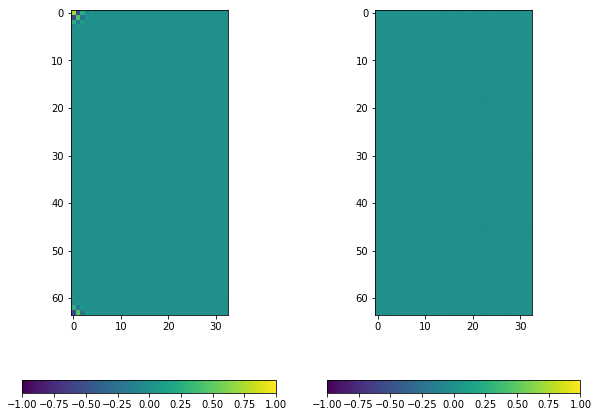

In [286]:
plt.subplot(1,2,1)
plt.imshow((P2 / D).real, vmin=-1, vmax=1)
plt.colorbar(orientation='horizontal')
plt.subplot(1,2,2)
plt.imshow((P2 / D).imag, vmin=-1, vmax=1)
plt.colorbar(orientation='horizontal');

In [287]:
ic2 = np.fft.irfft2(P2/D)
ic2.dtype, ic2.shape

(dtype('float64'), (64, 64))

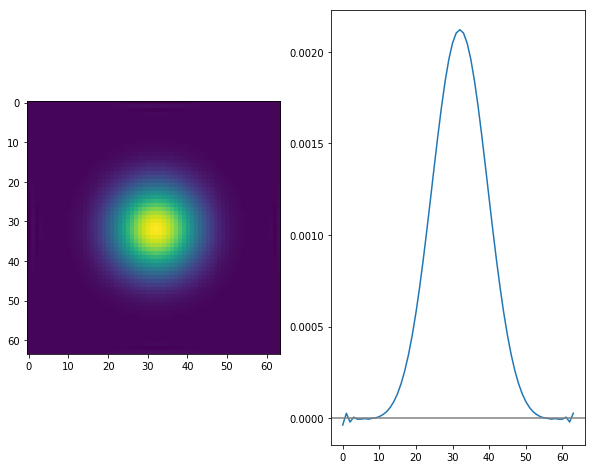

In [288]:
# this is the effective convolution filter to go from img2 to R.
plt.subplot(1,2,1)
plt.imshow(ic2)
plt.subplot(1,2,2)
plt.plot(ic2[cy,:]);
plt.axhline(0, color='0.5');

In [289]:
ic2[cy,:].min(), ic2[cy,:].max()
ic2.sum(), np.sqrt(np.sum(ic2**2))

(0.7071067811865474, 0.02799865296080226)

In [290]:
imgPR = np.fft.ifftshift(np.fft.irfft2(D))
imgPR.dtype, imgPR.shape

(dtype('float64'), (64, 64))

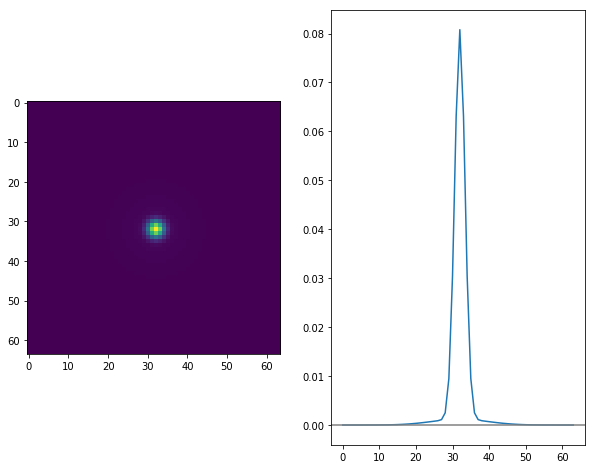

In [291]:
# This is the PSF of image R.
plt.subplot(1,2,1)
plt.imshow(imgPR)
plt.subplot(1,2,2)
plt.plot(imgPR[cy,:]);
plt.axhline(0, color='0.5');

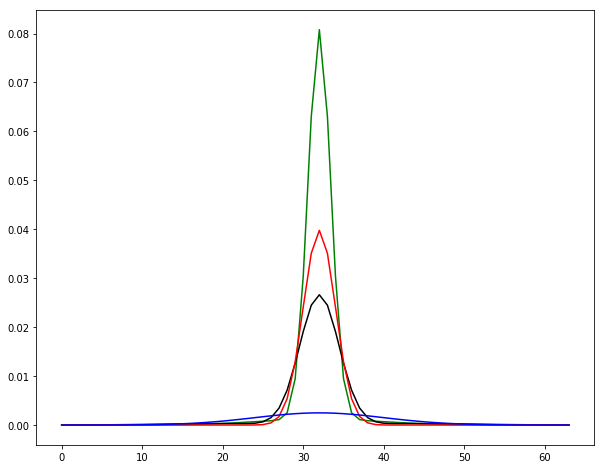

In [271]:
plt.plot(imgPR[cy,:], 'g');
plt.plot(imgR[cy,:], color='k')
plt.plot(img1[cy,:], color='r')
plt.plot(img2[cy,:], color='b');

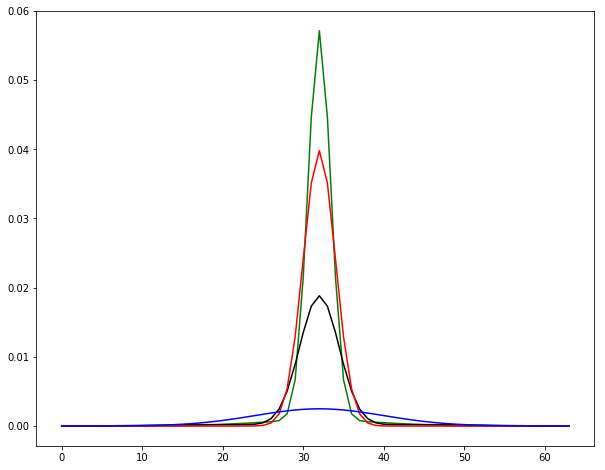

In [273]:
plt.plot(imgPR[cy,:] / np.sum(imgPR), 'g');
plt.plot(imgR[cy,:] / np.sum(imgR), color='k')
plt.plot(img1[cy,:] / np.sum(img1), color='r')
plt.plot(img2[cy,:] / np.sum(img2), color='b')

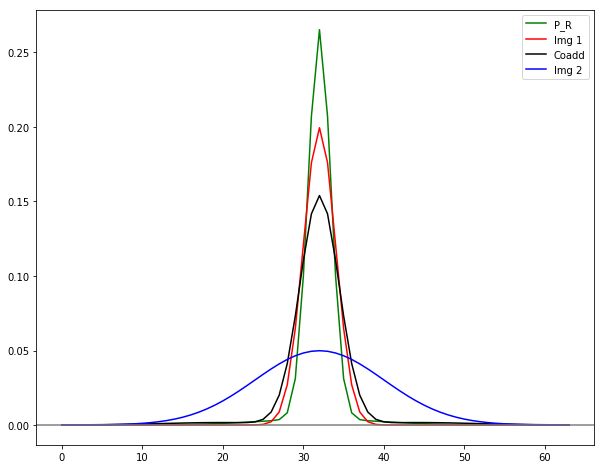

In [305]:
plt.plot(imgPR[cy,:] / np.sum(imgPR[cy,:]), 'g', label='P_R');
plt.plot(img1[cy,:] / np.sum(img1[cy,:]), color='r', label='Img 1')
plt.plot(imgR[cy,:] / np.sum(imgR[cy,:]), color='k', label='Coadd')
plt.plot(img2[cy,:] / np.sum(img2[cy,:]), color='b', label='Img 2')
plt.legend()
plt.axhline(0, color='0.5');

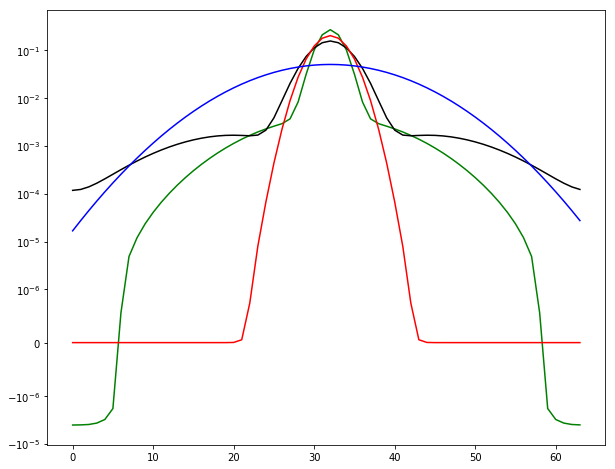

In [300]:
plt.plot(imgPR[cy,:] / np.sum(imgPR[cy,:]), 'g');
plt.plot(imgR[cy,:] / np.sum(imgR[cy,:]), color='k')
plt.plot(img1[cy,:] / np.sum(img1[cy,:]), color='r')
plt.plot(img2[cy,:] / np.sum(img2[cy,:]), color='b')
plt.yscale('symlog', linthreshy=1e-6)

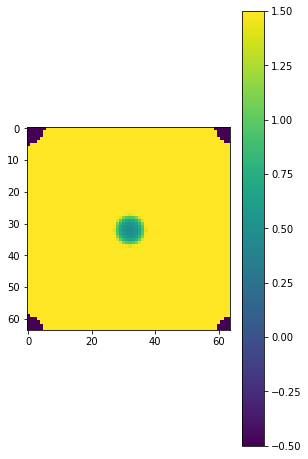

In [307]:
plt.subplot(1,2,1)
plt.imshow((imgR / imgR.sum()) / img1, vmin=-0.5, vmax=1.5)
plt.colorbar()

In [123]:
P1a = np.abs(P1)
imgP1a = np.fft.ifftshift(np.fft.irfft2(P1a))
imgP1a.dtype, imgP1a.shape

(dtype('float64'), (64, 64))

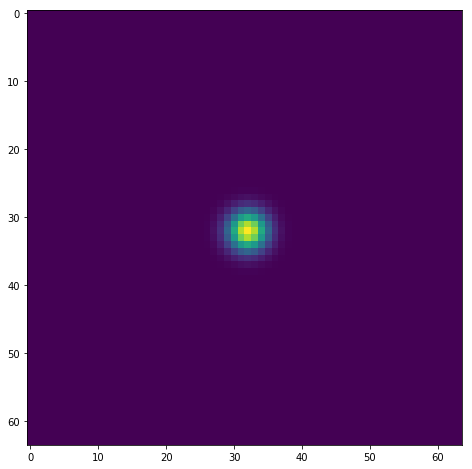

In [127]:
plt.imshow(imgP1a);

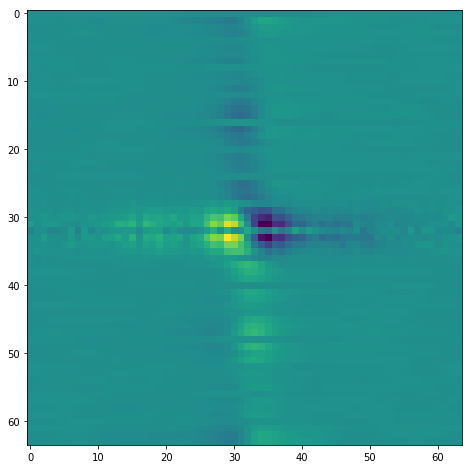

In [129]:
plt.imshow(imgP1a - psf1);

complex128 (64, 33)
float64 (64, 33)
complex128 (64, 33)


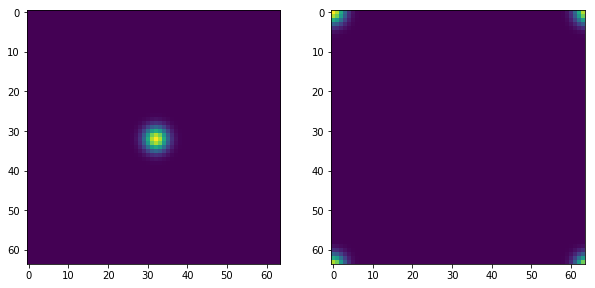

In [158]:
F1 = np.fft.rfft2(img1)
#F1 = np.fft.fftshift(F1)
print(F1.dtype, F1.shape)
F1 = np.abs(F1)
print(F1.dtype, F1.shape)
F1 = F1.astype(np.complex)
print(F1.dtype, F1.shape)
i1 = np.fft.irfft2(F1)
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(i1);